## Import Stack

In [12]:
from pystac_client import Client
import planetary_computer
import rioxarray
import pprint
from IPython.display import Image
%matplotlib inline
import geopandas

## Fetch Landsat 8, Level 2 Data of Maryland area between June and July of 2020

In [13]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
time_range = "2020-06-01/2020-07-31"
bbox = [-76.964657,38.978967,-76.928008,39.002783]

search = catalog.search(collections=["landsat-8-c2-l2"],
bbox=bbox, 
datetime=time_range,
query={"eo:cloud_cover": {"lt": 20}})

items = search.get_all_items() # Returns pystac.item_collection.ItemCollection
len(items)

2

Show first 5 assets of the first item in the Collection

In [14]:
item = items[0] # pystac.item
first_item_asset = item.assets['ANG'] # pystac.asset
preview_count = 0
for asset_key, asset in item.assets.items():
    if preview_count < 5:
        print(f"{asset_key} - {asset.title}")
        preview_count+= 1

ANG - Angle Coefficients File
SR_B1 - Coastal/Aerosol Band (B1)
SR_B2 - Blue Band (B2)
SR_B3 - Green Band (B3)
SR_B4 - Red Band (B4)


## Render item assets to image

In [15]:
Image(url=item.assets["rendered_preview"].href, width=500)

## Get Signed COG href

In [16]:
cog_signed_href = planetary_computer.sign(item).assets["SR_B2"].href

## Open COG and view metadata

In [17]:
rds = rioxarray.open_rasterio(cog_signed_href, overview_level=4).squeeze()
rds

<xarray.DataArray (y: 249, x: 245)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
Coordinates:
    band         int64 1
  * x            (x) float64 2.225e+05 2.234e+05 ... 4.555e+05 4.564e+05
  * y            (y) float64 4.426e+06 4.425e+06 ... 4.189e+06 4.188e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

## Render Cog

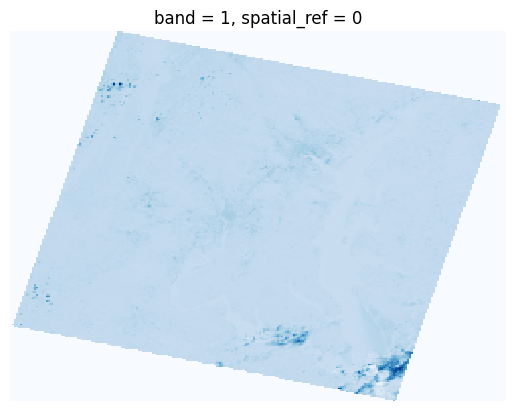

In [18]:
img = rds.plot(cmap="Blues", add_colorbar=False)
img.axes.set_axis_off();

## View items on map!

In [19]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=[-124.2751, 45.5469, -110.9613, 47.7458],
    datetime="2020-12-26/2020-12-31",
)
items = search.get_all_items()

df = geopandas.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")

df[["geometry", "datetime", "s2:mgrs_tile", "eo:cloud_cover"]].explore(
    column="eo:cloud_cover", style_kwds={"fillOpacity": 0.1}
)